In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Import Fashion MNIST Data Set

In [2]:
import tensorflow as tf
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Show an image

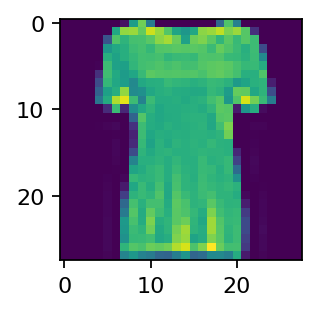

In [3]:
fig = plt.figure(figsize=(2,2), dpi=160, facecolor='w')
ax = fig.add_subplot(111)

ax.imshow(train_images[10])
ax.grid(False)

# Show class examples

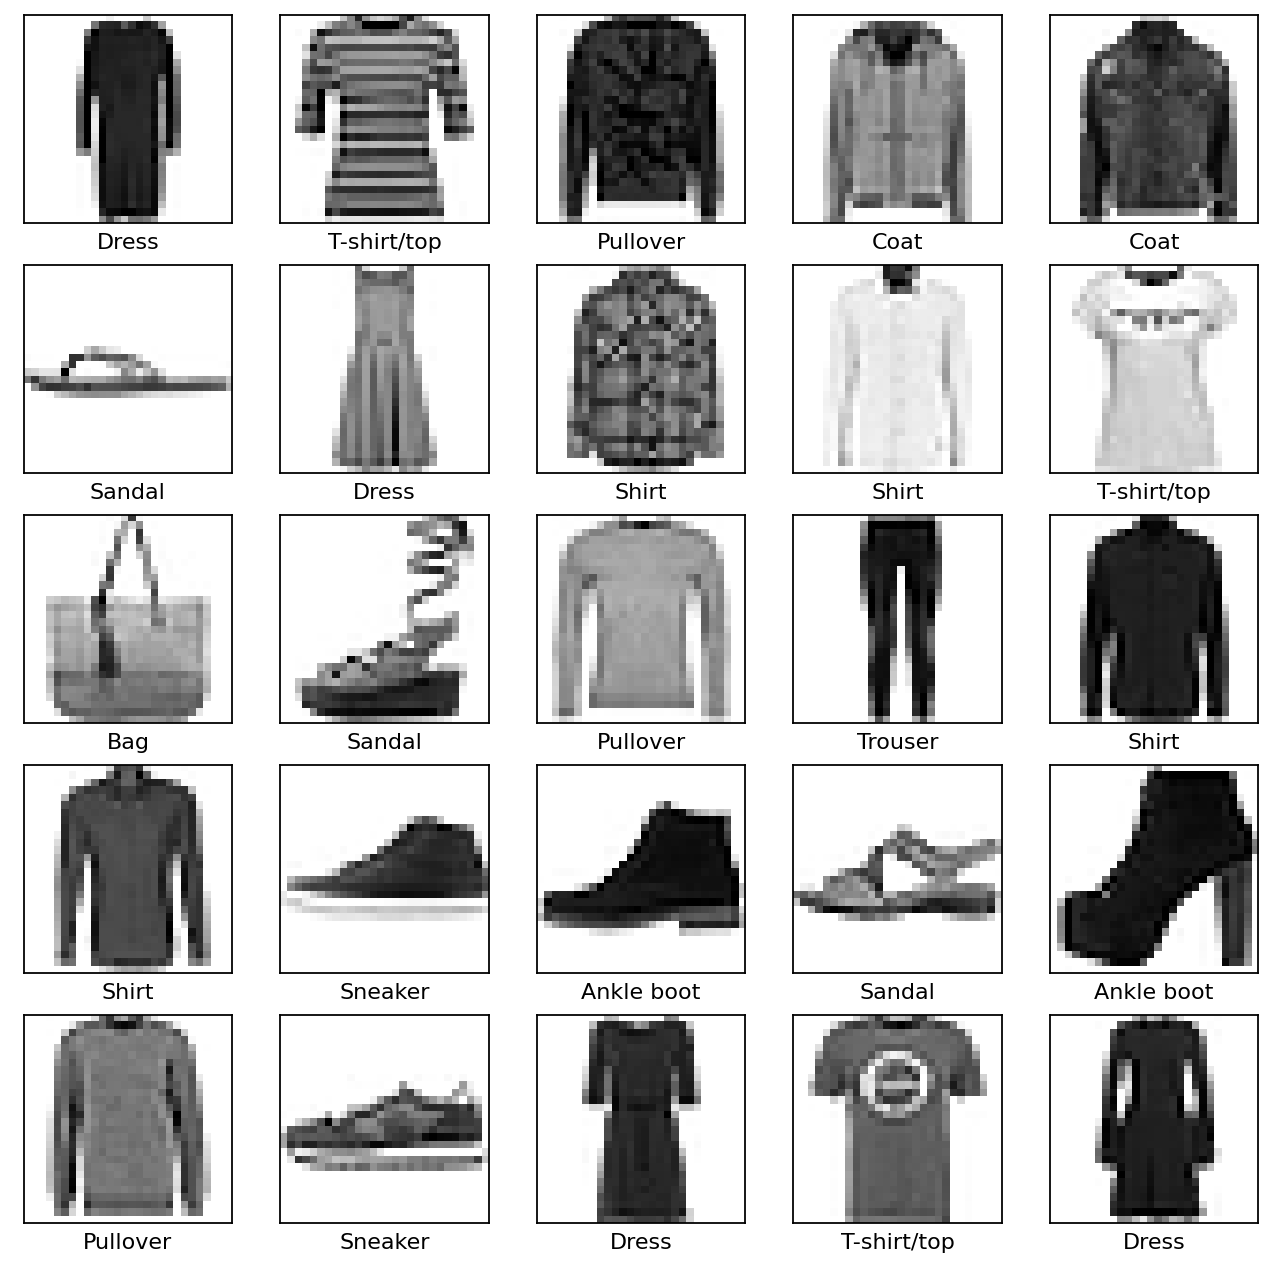

In [4]:
fig = plt.figure(figsize=(10,10), dpi=160, facecolor='w')
offset = 25
for i in range(25):
    ax = fig.add_subplot(5,5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(train_images[i+offset], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_labels[i+offset]])
    

# Subset Data

In [5]:
from collections import Counter

## scale values of train and test
train_images = train_images / 255.0
test_images = test_images / 255.0

## subset the data
subset = np.array([0,1,2,3,4])
train_subset = np.in1d(train_labels, subset)
train_labels = train_labels[train_subset]
train_images = train_images[train_subset]

test_subset = np.in1d(test_labels, subset)
test_labels = test_labels[test_subset]
test_images = test_images[test_subset]

## flatten images to 784 px vectors
X_train = np.array([i.flatten() for i in train_images])
X_test = np.array([i.flatten() for i in test_images])
y_train = train_labels
y_test = test_labels

## print basic info
print(f'X_train: {X_train.shape}')
class_info = list(sorted(Counter(y_train).items()))
print(f'num classes: {len(class_info)}, classes {[i[0] for i in class_info]}')
print(f'class samples: {[i[1] for i in class_info]}')
print(f'class balance: {[round(i[1]/X_train.shape[0],2) for i in class_info]}')

X_train: (30000, 784)
num classes: 5, classes [0, 1, 2, 3, 4]
class samples: [6000, 6000, 6000, 6000, 6000]
class balance: [0.2, 0.2, 0.2, 0.2, 0.2]


# Reduce Dimensionality

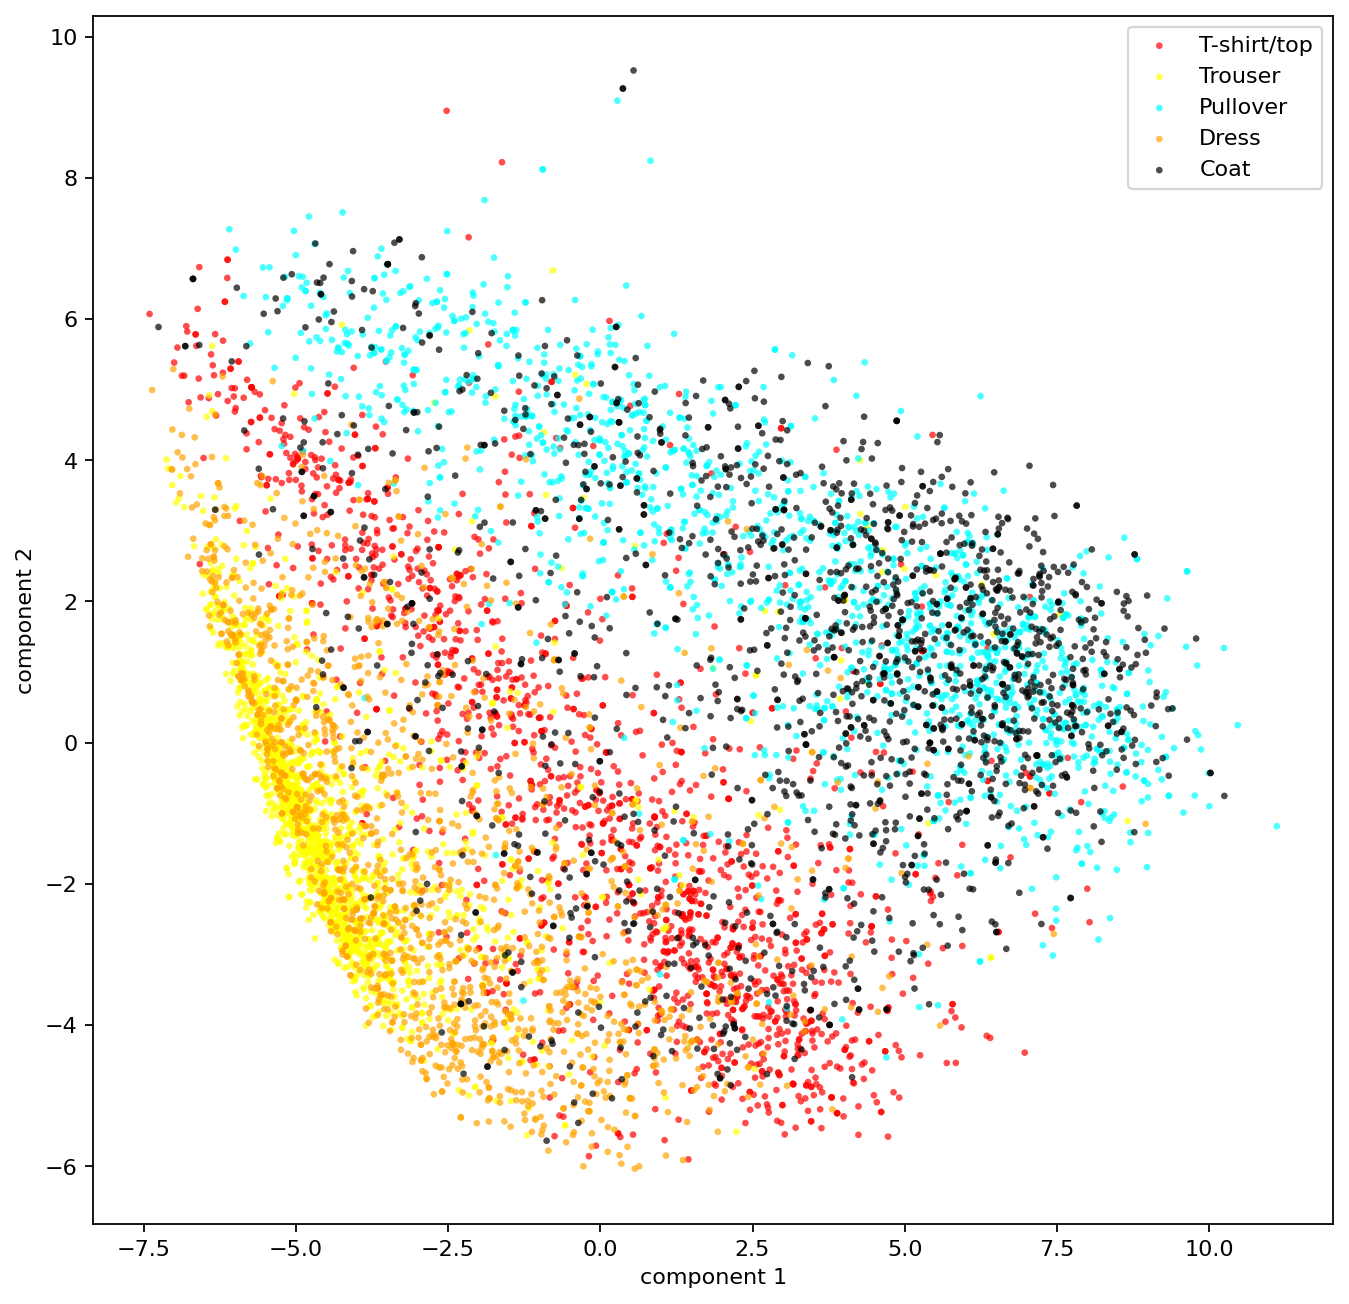

In [17]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [18]:
# make_3D_projection()

Text(0, 0.5, 'cumulative explained variance')

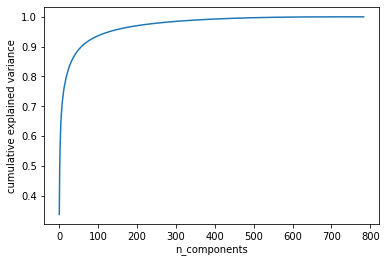

In [19]:
%matplotlib inline
pca = PCA().fit(X_train)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.cumsum(pca. explained_variance_ratio_))
ax.set_xlabel('n_components')
ax.set_ylabel('cumulative explained variance')

# PCA in Pipeline

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import time

pipe = Pipeline([('pca', PCA()),
                 ('svm', SVC(class_weight='balanced'))])

param_grid = {
    'pca__n_components': [5, 10, 25],
    'svm__C': [0.001, 0.1, 10.0],
    'svm__gamma': [0.1, 0.01]
}

## grid search
saved_model = 'pca-svm.joblib'
if not os.path.exists(saved_model):
    time_start = time.time()
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, iid=False, n_jobs=-1)
    grid.fit(X_train, y_train)
    joblib.dump(grid, saved_model)
    print('train time ', time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print(f'loading {saved_model} from file')
    grid = joblib.load(saved_model)
    
print(grid.best_params_)

/Users/samuelc/.pyenv/versions/3.6.6/envs/ai_ent_wf/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train time  00:20:02
{'pca__n_components': 25, 'svm__C': 10.0, 'svm__gamma': 0.01}


# Model Evaluation

In [26]:
from sklearn.metrics import classification_report
# look at model performance
y_pred = grid.predict(X_test)
print('-->'.join(pipe.named_steps.keys()))
print(classification_report(y_test, y_pred, target_names=np.array(class_names)[subset]))


pca-->svm
              precision    recall  f1-score   support

 T-shirt/top       0.93      0.93      0.93      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.85      0.84      0.84      1000
       Dress       0.90      0.91      0.90      1000
        Coat       0.84      0.86      0.85      1000

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

